In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Questions

1. Build a model which is better than the bank model.
2. Using the (-1,1,0) rule, compare bank profitability vs your model profitability
3. Most important variable and how does "is_employed" impact the model 
4. Other variables to include?

Read data

In [2]:
borrower = pd.read_csv("borrower_table.csv")
loan = pd.read_csv("loan_table.csv")
print("Borrower table: ", borrower.shape)
print("loan table: ", loan.shape)

Borrower table:  (101100, 12)
loan table:  (101100, 5)


In [3]:
print("Are all loan ids in borrower table unique: ", len(borrower) == len(borrower['loan_id'].unique()))
print("Are all loan ids in loan table unique: ", len(loan) == len(loan['loan_id'].unique()))

Are all loan ids in borrower table unique:  True
Are all loan ids in loan table unique:  True


1. 54947 of all loans is the first time
2. 53446 loan applications are not granted
3. There are 6972 missing values in avg_percentage_credit_card

In [4]:
#join two tables and check null values other than 'l_r, f_r_p_l, c_r_o_l'
data = pd.merge(borrower, loan, on = 'loan_id', how = 'inner')
data['date'] = pd.to_datetime(data['date'])

print("new data has shape: ", data.shape, '\n')
print(data.isnull().sum())

new data has shape:  (101100, 16) 

loan_id                                                0
is_first_loan                                          0
fully_repaid_previous_loans                        54947
currently_repaying_other_loans                     54947
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year     6972
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
loan_purpose                                           0
date                                                   0
loan_granted                                           0
loan_repaid                                        53446
dtype: int64


In [5]:
#some data type transformation
cols = ['fully_repaid_previous_loans', 'currently_repaying_other_loans', 'is_employed', 'loan_granted','loan_repaid']
for col in cols:
    data[col] = data[col].astype('category')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101100 entries, 0 to 101099
Data columns (total 16 columns):
loan_id                                            101100 non-null int64
is_first_loan                                      101100 non-null int64
fully_repaid_previous_loans                        46153 non-null category
currently_repaying_other_loans                     46153 non-null category
total_credit_card_limit                            101100 non-null int64
avg_percentage_credit_card_limit_used_last_year    94128 non-null float64
saving_amount                                      101100 non-null int64
checking_amount                                    101100 non-null int64
is_employed                                        101100 non-null category
yearly_salary                                      101100 non-null int64
age                                                101100 non-null int64
dependent_number                                   101100 non-null int64
loan_

In [6]:
data.head(3)

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_purpose,date,loan_granted,loan_repaid
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3,business,2012-01-31,0,NaN
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1,investment,2012-11-02,0,NaN
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8,other,2012-07-16,1,1.0


## Exploratory data analysis first

For both first time borrower and multi time borrower, the *no granted rate* is higher than *grant rate*

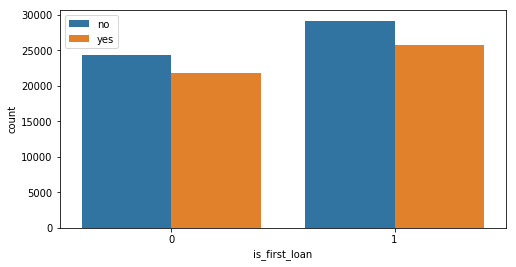

In [12]:
#is_first_loan, take a look at its distribution
fig, ax = plt.subplots(figsize = (8,4))
sns.countplot(x = 'is_first_loan', ax = ax, hue = 'loan_granted', data=data)
plt.legend(['no','yes'])

Analyze four bank card related features separated by loan_granted:  *total_credit_card_limit*, *avg_percentage_credit_card_limit_used_last_year*, *checking_amount*, *saving_amount*

1. **Total credit card limit** plays a very important role in deciding if loan_granted based on the left figure because those who are granted have much higher credit_card_possession rate and higher limit
2. **credit card usage** is also distinguishable between two groups since those who are granted loan have smaller usages
3. **checking, saving amount** is less distinguishable, but still, those who are granted loan in average have higher amount 

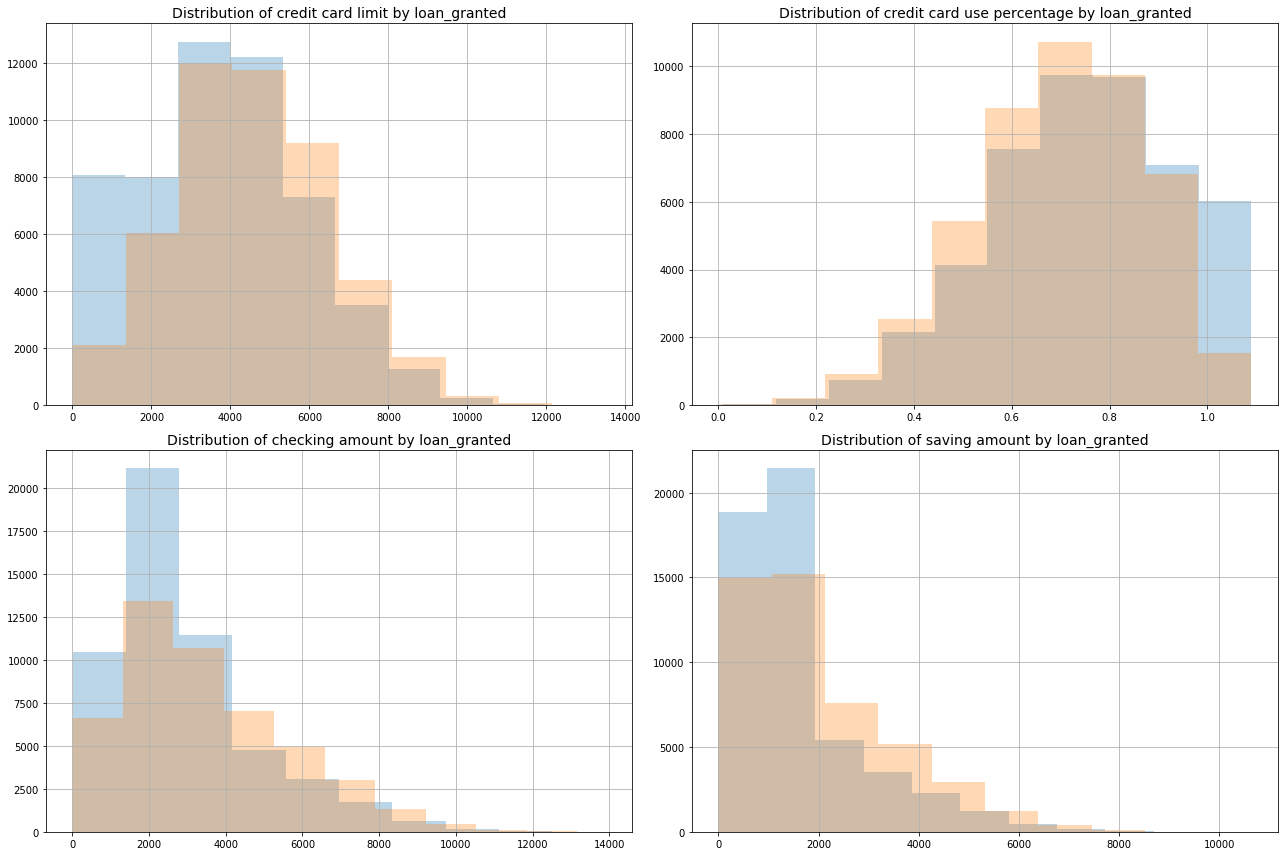

In [25]:
#credit card limit
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (18,12))
data.groupby('loan_granted').total_credit_card_limit.hist(alpha = 0.3, ax = ax1)
ax1.set_title('Distribution of credit card limit by loan_granted', fontsize = 14)
#percentage
data.groupby("loan_granted").avg_percentage_credit_card_limit_used_last_year.hist(alpha = 0.3, ax=ax2)
ax2.set_title("Distribution of credit card use percentage by loan_granted", fontsize = 14)
#checking amount
data.groupby("loan_granted").checking_amount.hist(alpha = 0.3, ax=ax3)
ax3.set_title("Distribution of checking amount by loan_granted", fontsize = 14)
#savings amount
data.groupby("loan_granted").saving_amount.hist(alpha = 0.3, ax=ax4)
ax4.set_title("Distribution of saving amount by loan_granted", fontsize = 14)
plt.tight_layout()

Analyze *fully_repaid_previous_loans* and *currently_repaying_other_loans* by loan_granted. These two features mainly focus on loan history of the borrower, and see how this affects current status

1. For **fully_repaid_previous_loans**, this does not seem to affect loan decision because people in either groups are granted, and the grant rate is even higher for those who have not repaid
2. For **currently_repaying_other_loans**, this definitely affects loan decision since those who are not currently paying for other loans have higher grant rate than those who are

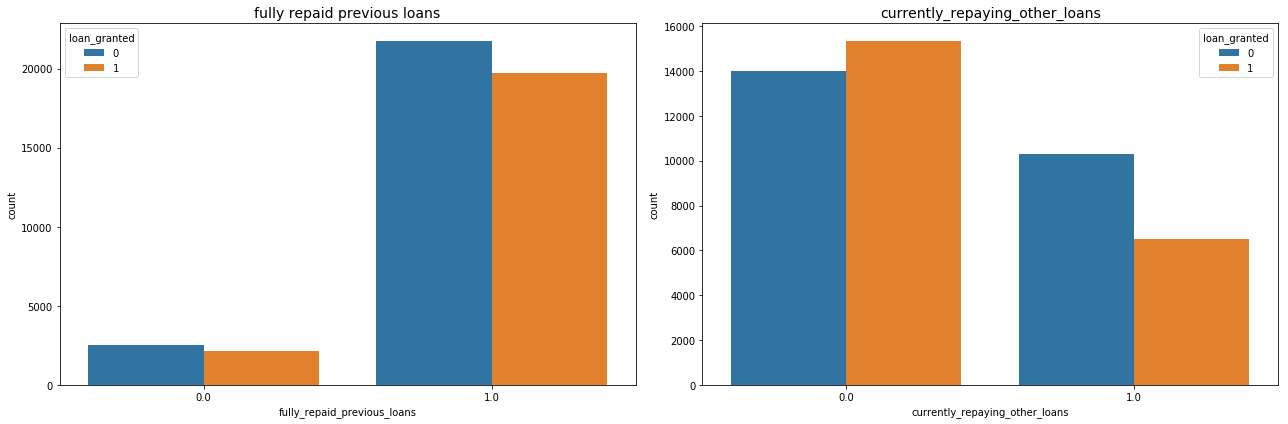

In [34]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x = 'fully_repaid_previous_loans', data = data,hue = 'loan_granted', ax = ax[0])
ax[0].set_title("fully repaid previous loans",fontsize=14)

sns.countplot(x = 'currently_repaying_other_loans',data=data, hue = 'loan_granted', ax = ax[1])
ax[1].set_title("currently_repaying_other_loans",fontsize=14)
plt.tight_layout()

Next we analyze effect of employment on loan granted using *is_employed* and *yearly_salary*

In [44]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
#impute missing values by using KNN

def impute_credit_card(df, k_list):
    #remove two features
    cols_to_remove = ['loan_id','date']
    df.drop(cols_to_remove, axis = 1)
    #encode text to categorical values
    le = LabelEncoder()
    df['loan_purpose'] = le.fit_transform(df['loan_purpose'])
    #split train, test
    train, test = df[df['avg_percentage_credit_card_limit_used_last_year'].isnull() == False], \
                df[df['avg_percentage_credit_card_limit_used_last_year'].isnull() == True]
    X_train, X_test, y_train = train.loc[:, train.columns != 'avg_percentage_credit_card_limit_used_last_year'], \
                test.loc[:,test.columns !='avg_percentage_credit_card_limit_used_last_year'], \
                train.avg_percentage_credit_card_limit_used_last_year
    
    #scale all columns before fit KNN model and save mean/var of each feature
    for col in X_train.columns:
        scaler = StandardScaler()
        scaler.fit(X_train[col].reshape(-1, 1))
        X_train[col] = scaler.transform(X_train[col].reshape(-1, 1))
        X_test[col] = scaler.transform(X_test[col].reshape(-1, 1))
    #find best k
    params = {"n_neighbors": k_list}
    knn = KNeighborsRegressor()
    clf = GridSearchCV(knn, params)
    clf.fit(X_train, y_train)
    model = clf.best_estimator_
    #make predictions
    print(X_test.shape)
    return model.fit(X_test)